#### This Script does 
- Remove duplicate records
- From available data, calculate below things for each customer and include them as features in the dataset. 
	- Average order value (AOV)
	- Purchase Frequency (PF)
	- Repeat rate, churn rate
	- Profit margin
	- Customer Value(CV)
	- Customer Life time Value(CLTV)
- Remove Outliers
- Perform Cross correlation and remove correlated features.
##### Regression :
- Break dataset into Train and test datasets by considering CLTV as dependent variable.
- Predict CLTV using below regression techniques
	- Linear Regression
	- Random Forest Regression
	- Support Vector Regression
	- SVR with RBF Kernal
	- SVR with Polynomial Kernal
	- Bagging
	- Gradient Boosting
- Write the predictions for test data from all models to a CSV file.
- Write Metrics(R_Square, RMSE) values to a dataframe for better comparison.
##### Clustering:
- Perform Z-score normalization on the data
- Find natural groupings in the dataset using Kmeans and DBscan. 
- Pick the clusters based on better Sihouette score and better data distribution in clusters.
- Assign the clusters to raw dataset(pre-scaling)
##### Classification:
- Create generic functions for classification and their metrics calculation.
- Break dataset into Train and test datasets by considering cluster number as dependent variable. 
- Goal is to identify the class of a new customer based on existing customers dataset.
- Predict Customer Class using below Classification techniques
	- Logistic Regression
	- K Nearest Neighbours
	- Random Forest
	- Support Vector Machine
	- SVM with RBF Kernal
	- SVM with Polynomial Kernal
	- Bagging
	- Gradient Boosting
	- Deep Neural Network
- Write the predictions for test data from all models to a CSV file.
- Write AUC ROC Scores from all models to a dataframe for better comparison.
- Additional work 
- Balance the dataset for classification using SMOTE techinque
- Predict Customer Class using same classification techique tried above.

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import os
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

print('pandas: {}'.format(pd.__version__)) # Printing the version of pandas
print('numpy: {}'.format(np.__version__)) # Printing the version of Numpy

/home/kartikey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


pandas: 1.0.5
numpy: 1.19.2


In [2]:
# Data read - All Required data  are in datafolder
InputdataFolder  = os.getcwd() + "/DataStack"
OutputdataFolder = os.getcwd() + "/Output"


df_initial = pd.read_csv(OutputdataFolder + "/Capstone_Customer_Retail_Analytics_Pass-1.csv", parse_dates=['InvoiceDate'])

print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (379095, 14)


In [3]:
df_initial.columns

Index(['InvoiceNo', 'ItemCode', 'item_Desc', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'CustomerName', 'Country',
       'InvoiceYearMonth', 'Revenue', 'MinPurchaseDate',
       'MinPurchaseYearMonth', 'UserType'],
      dtype='object')

In [4]:
df_initial.head()

,InvoiceNo,ItemCode,item_Desc,Quantity,InvoiceDate,UnitPrice,CustomerID,CustomerName,Country,InvoiceYearMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth,UserType
0,536365,10742201412,Microclimate Headband-Black/Black,6,2010-12-01 08:26:00,2.55,17850.0,Matthew-Clark,Argentina.,2010-12,15.30,2010-12-01 08:26:00,2010-12,New
1,536365,10742201610,Microclimate Headband-Blazing Orange/Charcoal,6,2010-12-01 08:26:00,3.39,17850.0,Matthew-Clark,Argentina.,2010-12,20.34,2010-12-01 08:26:00,2010-12,New
2,536365,10742201719,Microclimate Headband-Coral Rose/Charcoal,8,2010-12-01 08:26:00,2.75,17850.0,Matthew-Clark,Argentina.,2010-12,22.00,2010-12-01 08:26:00,2010-12,New
3,536365,10742201818,SF-2 LS-Small,6,2010-12-01 08:26:00,3.39,17850.0,Matthew-Clark,Argentina.,2010-12,20.34,2010-12-01 08:26:00,2010-12,New
4,536365,10742202211,SF-2 LS-Medium,6,2010-12-01 08:26:00,3.39,17850.0,Matthew-Clark,Argentina.,2010-12,20.34,2010-12-01 08:26:00,2010-12,New


In [5]:
df_initial.dtypes

InvoiceNo                        int64
ItemCode                         int64
item_Desc                       object
Quantity                         int64
InvoiceDate             datetime64[ns]
UnitPrice                      float64
CustomerID                     float64
CustomerName                    object
Country                         object
InvoiceYearMonth                object
Revenue                        float64
MinPurchaseDate                 object
MinPurchaseYearMonth            object
UserType                        object
dtype: object

In [6]:
# CustomerID from float to int
df_initial['CustomerID'] = df_initial['CustomerID'].apply(lambda x: int(x))

In [7]:
# Drop duplicates
df_initial.drop_duplicates(keep='last',inplace=True)
df_initial.shape

(374184, 14)

In [8]:
# Countrywise distribution of number of transactions
temp = df_initial.groupby(['Country']).agg({'InvoiceNo' : lambda x: 100*len(x)/len(df_initial) })
temp.rename(columns={"InvoiceNo":"Percent of total Transactions"},inplace=True)
# See top five countries
temp.head()

,Percent of total Transactions
Country,
Argentina.,89.089058
Australia,2.060751
Austria,0.315353
Bahrain,0.597567
Belgium,2.490486


#### We analyse only Argentina as it has almost 90% of all transactions

In [9]:
Argen_trans = df_initial[df_initial['Country']=='Argentina.']
Argen_trans.describe()

,InvoiceNo,ItemCode,Quantity,UnitPrice,CustomerID,Revenue
count,333357.000000,3.333570e+05,333357.000000,333357.000000,333357.000000,333357.000000
mean,559710.838284,7.853990e+11,11.923730,2.879251,15550.817736,20.317479
std,12698.893922,1.936002e+12,135.285583,4.401943,1591.743240,165.122170
min,536365.000000,2.000882e+07,1.000000,0.040000,12346.000000,0.060000
25%,548659.000000,2.040486e+07,2.000000,1.250000,14198.000000,4.200000
50%,560732.000000,2.053730e+07,4.000000,1.950000,15521.000000,10.440000
75%,571039.000000,4.155463e+10,12.000000,3.750000,16931.000000,17.850000
max,579885.000000,9.311010e+12,74215.000000,649.500000,18287.000000,77183.600000


In [10]:
# Need only these columns for CLTV computation
req_columns = ['CustomerID','InvoiceNo','InvoiceDate','Quantity','UnitPrice','Revenue']
Argen_trans = Argen_trans.reindex(columns=req_columns)
Argen_trans.head()

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Revenue
0,17850,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,20.34


In [11]:
Argen_trans.dtypes

CustomerID              int64
InvoiceNo               int64
InvoiceDate    datetime64[ns]
Quantity                int64
UnitPrice             float64
Revenue               float64
dtype: object

In [12]:
Argen_trans.shape

(333357, 6)

### CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) * Profit_margin
    - Average order value of customer (AOV) = Total Revenue of customer/ Total number of transactions by customer
    - Purchase frequency of customer(PF) = Total number of transactions by customer/ Total number of customers
    - Repeat rate = Number of customer with more than 1 order / Unique number of customer
    - Churn rate = 1 - Repeat rate
    - Profit Margin of customer = Approximate profit on total sale * Total revenue of customer
    - Customer Value (CV)  = (AOV * PF)/churn rate
    - Customer Lifetime Value (CLTV) = CV * Profit Margin

In [13]:
trans_group = Argen_trans.groupby('CustomerID').agg({'InvoiceDate': lambda x: (x.max()-x.min()).days, # Number of days of involvement by customer
                                 'InvoiceNo': lambda x: len(x), # Total number of transactions of customer
                                 'Quantity' : lambda x: sum(x), # Total number of units bought by customer
                                 'Revenue': lambda x: sum(x)    # Total revenue of customer
                                })
trans_group.rename(columns={"InvoiceDate":"num_days_involved", "InvoiceNo":"num_transactions", "Quantity":"num_units", "Revenue":"money_spent"}, inplace=True)
trans_group.head()

,num_days_involved,num_transactions,num_units,money_spent
CustomerID,,,,
12346,0,1,74215,77183.60
12747,347,96,1153,3757.51
12748,363,4105,24393,30652.63
12749,190,159,1243,3277.82
12820,282,47,607,731.99


In [14]:
# Average order value calculation
trans_group['AOV'] = trans_group['money_spent']/trans_group['num_transactions']
trans_group.head()

,num_days_involved,num_transactions,num_units,money_spent,AOV
CustomerID,,,,,
12346,0,1,74215,77183.60,77183.600000
12747,347,96,1153,3757.51,39.140729
12748,363,4105,24393,30652.63,7.467145
12749,190,159,1243,3277.82,20.615220
12820,282,47,607,731.99,15.574255


In [15]:
# Purchase Frequency calculation
purchase_frequency = sum(trans_group['num_transactions']/len(trans_group))

# Repeat rate calculation
repeat_rate = trans_group[trans_group['num_transactions']>1].shape[0]/len(trans_group.index)

#Churn rate calculation
churn_rate  = 1 - repeat_rate

In [16]:
print(f"Purchase frequency : {purchase_frequency}")
print(f"Repeat rate : {repeat_rate}")
print(f"Churn rate : {churn_rate}")

Purchase frequency : 85.87248840803852
Repeat rate : 0.9827408552292632
Churn rate : 0.017259144770736756


In [17]:
# Profit Margin Calculation
approx_profit = 0.04 # Considering 4% profit on total sales
trans_group['profit_margin'] = approx_profit*trans_group['money_spent']
trans_group.head()

,num_days_involved,num_transactions,num_units,money_spent,AOV,profit_margin
CustomerID,,,,,,
12346,0,1,74215,77183.60,77183.600000,3087.3440
12747,347,96,1153,3757.51,39.140729,150.3004
12748,363,4105,24393,30652.63,7.467145,1226.1052
12749,190,159,1243,3277.82,20.615220,131.1128
12820,282,47,607,731.99,15.574255,29.2796


In [18]:
# Customer Value calculation
trans_group['CV'] = (trans_group['AOV']*purchase_frequency)/churn_rate

In [19]:
# Customer lifetime Value calculation
trans_group['CLTV'] = trans_group['CV']*trans_group['profit_margin']

In [20]:
trans_group.head()

,num_days_involved,num_transactions,num_units,money_spent,AOV,profit_margin,CV,CLTV
CustomerID,,,,,,,,
12346,0,1,74215,77183.60,77183.600000,3087.3440,3.840253e+08,1.185618e+12
12747,347,96,1153,3757.51,39.140729,150.3004,1.947438e+05,2.927007e+07
12748,363,4105,24393,30652.63,7.467145,1226.1052,3.715261e+04,4.555301e+07
12749,190,159,1243,3277.82,20.615220,131.1128,1.025706e+05,1.344831e+07
12820,282,47,607,731.99,15.574255,29.2796,7.748936e+04,2.268857e+06


In [21]:
trans_group.describe()

,num_days_involved,num_transactions,num_units,money_spent,AOV,profit_margin,CV,CLTV
count,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3.882000e+03,3.882000e+03
mean,125.302937,85.872488,1023.920402,1744.712522,56.073636,69.788501,2.789931e+05,3.791271e+08
std,129.068597,202.154915,3385.208548,6705.800145,1262.067677,268.232006,6.279389e+06,1.912455e+10
min,0.000000,1.000000,1.000000,2.900000,1.450000,0.116000,7.214443e+03,8.368753e+02
25%,0.000000,16.000000,150.000000,291.127500,11.312617,11.645100,5.628568e+04,7.798324e+05
50%,83.000000,39.000000,354.000000,626.905000,17.266776,25.076200,8.591046e+04,2.098276e+06
75%,245.000000,96.000000,902.750000,1510.380000,24.326304,60.415200,1.210350e+05,6.367277e+06
max,364.000000,7204.000000,74215.000000,248171.760000,77183.600000,9926.870400,3.840253e+08,1.185618e+12


In [22]:
# As the CLTV(monetary value) is high, reduce the magnitude by converting the value to CLTV(in lakhs) by dividing the entire column by e+5.
trans_group['CLTV'] = trans_group['CLTV']/1e+5

In [23]:
trans_group.describe()

,num_days_involved,num_transactions,num_units,money_spent,AOV,profit_margin,CV,CLTV
count,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3.882000e+03,3.882000e+03
mean,125.302937,85.872488,1023.920402,1744.712522,56.073636,69.788501,2.789931e+05,3.791271e+03
std,129.068597,202.154915,3385.208548,6705.800145,1262.067677,268.232006,6.279389e+06,1.912455e+05
min,0.000000,1.000000,1.000000,2.900000,1.450000,0.116000,7.214443e+03,8.368753e-03
25%,0.000000,16.000000,150.000000,291.127500,11.312617,11.645100,5.628568e+04,7.798324e+00
50%,83.000000,39.000000,354.000000,626.905000,17.266776,25.076200,8.591046e+04,2.098276e+01
75%,245.000000,96.000000,902.750000,1510.380000,24.326304,60.415200,1.210350e+05,6.367277e+01
max,364.000000,7204.000000,74215.000000,248171.760000,77183.600000,9926.870400,3.840253e+08,1.185618e+07


#### Outlier removal

In [24]:
# For each column, first it computes the Z-score of each value in the column, relative to the column mean and standard deviation. 
#  Then is takes the absolute of Z-score because the direction does not matter, only if it is below the threshold. 
#  .all(axis=1) ensures that for each row, all column satisfy the constraint. Finally, result of this condition is used to index the dataframe. 
# The constraint is that for each column, its value should lie within 2 standard deviations of the mean
trans_group_no_outlier = trans_group[(np.abs(stats.zscore(trans_group)) < 2).all(axis=1)]

In [25]:
# Check stats after removing outliers
trans_group_no_outlier.describe()

,num_days_involved,num_transactions,num_units,money_spent,AOV,profit_margin,CV,CLTV
count,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3.773000e+03,3773.000000
mean,120.310893,68.673999,688.483965,1169.681460,28.269943,46.787258,1.406565e+05,89.432904
std,126.467142,82.216783,934.411649,1611.722333,59.155920,64.468893,2.943290e+05,466.809782
min,0.000000,1.000000,1.000000,2.900000,1.450000,0.116000,7.214443e+03,0.008369
25%,0.000000,16.000000,147.000000,285.740000,11.590690,11.429600,5.766922e+04,7.536436
50%,74.000000,38.000000,338.000000,604.640000,17.247731,24.185600,8.581570e+04,19.807416
75%,234.000000,89.000000,832.000000,1393.060000,23.941500,55.722400,1.191204e+05,59.131396
max,364.000000,480.000000,7347.000000,15030.730000,1687.200000,601.229200,8.394626e+06,22661.460312


#### Correlation

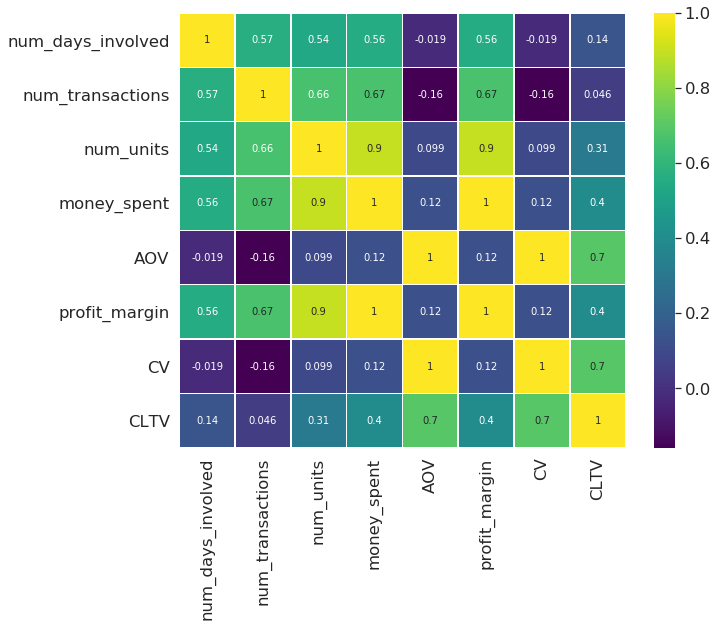

In [26]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(trans_group_no_outlier.corr(), cmap='viridis', linewidths=0.5, ax=ax, annot=True)
plt.show()

##### Correlated features: 
    - num_units and money_spent (0.899367) 
    - num_units and profit_margin (0.899367)
    - AOV and CV (1)
    - profit_margin and money_spent (1)
    
##### Correlation with target of these correlated features: 
    - num_units and CLTV (0.312630)
    - money_spent and CLTV (0.399156)
    - profit_margin and CLTV (0.399156)
    - AOV and CLTV (0.696063)
    - CV and CLTV (0.696063)
    
##### Choosing which features to remove
    - num_units and money_spent, we remove num_units as it has lower correlation with target. 
    - num_units and profit_margin, num_units already removed 
    - AOV and CV, we remove CV as we can remove any of them as they both have equal correlation with target.
    - profit_margin and money_spent, we remove profit_margin.

In [27]:
# We remove num_units, CV, profit_margin as correlation is greater than 0.8 in H2o and sklearn data prep

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, BaggingClassifier, BaggingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_validate,train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as sm_pipe

#### H20 Data prep

In [29]:
from sklearn.model_selection import train_test_split
X = trans_group_no_outlier[['num_days_involved','num_transactions','money_spent','AOV']]
y = trans_group_no_outlier[['CLTV']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

X_train['CLTV'] = y_train
X_test['CLTV']  = y_test

X_test.to_csv(OutputdataFolder + "/CustomerIDTest.csv", index=True)

X_train.to_csv(OutputdataFolder + "/H2oTrainFile.csv", index=False)
X_test.to_csv(OutputdataFolder + "/H2oTestFile.csv", index=False)

/home/kartikey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/kartikey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


#### SKlearn data prep (Regression)

#### Functions for ML - 

In [30]:
# Prepare Data for training and testing
X = trans_group_no_outlier[['num_days_involved','num_transactions','money_spent','AOV']]
y = trans_group_no_outlier['CLTV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Model_accuracy = {}

In [31]:
def regression_model(X_tr, y_tr, X_te, y_te, model, metrics):
    pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', model)])
    scores   = cross_validate(pipeline, X_tr, y_tr, cv=10, scoring=metrics, return_estimator=True, n_jobs=-1)
    
    max_index      = scores['test_r2'].argmax()
    best_estimator = scores['estimator'][max_index]
    
    y_pred = best_estimator.predict(X_te)
    rmse   = math.sqrt(mean_squared_error(y_te, y_pred))
    r2     = best_estimator.score(X_te, y_te)
    
    return rmse, r2, y_pred

## Regression

#### Linear regression

In [32]:
# Predict CLTV using linear regression model
linreg        = LinearRegression()
linreg_output = regression_model(X_train, y_train, X_test, y_test, linreg, ('neg_root_mean_squared_error','r2'))

# Check the metrics of linear regression
print('R squared score for linear regression model is', linreg_output[1])
print('RMSE score for linear regression model is', linreg_output[0])

R squared score for linear regression model is 0.7010802744400352
RMSE score for linear regression model is 156.90130512612447


#### RandomForest

In [33]:
# Predict CLTV using Random Forest Regressor model
rf        = RandomForestRegressor(n_estimators= 1000, random_state=42)
rf_output = regression_model(X_train, y_train, X_test, y_test, rf, ('neg_root_mean_squared_error','r2'))

# Check the metrics
print('R squared score for Random Forest model is', rf_output[1])
print('RMSE score for Random Forest model is', rf_output[0])

R squared score for Random Forest model is 0.8922936434716268
RMSE score for Random Forest model is 94.18243968631927


#### SVR

In [34]:
# Predict CLTV using Support Vector Regressor model with RBF Kernal
svr_rbf         = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_rbf_output  = regression_model(X_train, y_train, X_test, y_test, svr_rbf, ('neg_root_mean_squared_error','r2'))

# Check the metrics
print('R squared score for SVR model with rbf kernel is', svr_rbf_output[1])
print('RMSE score for SVR model with rbf kernel is', svr_rbf_output[0])

R squared score for SVR model with rbf kernel is 0.590793348209204
RMSE score for SVR model with rbf kernel is 183.57799025252442


In [35]:
# Predict CLTV using linear Support Vector Regressor model
svr_lin         = SVR(kernel='linear', C=100, gamma='auto')
svr_lin_output  = regression_model(X_train, y_train, X_test, y_test, svr_lin, ('neg_root_mean_squared_error','r2'))

# Check the metrics
print('R squared score for Linear SVR model is', svr_lin_output[1])
print('RMSE score for Linear SVR model is', svr_lin_output[0])

R squared score for Linear SVR model is 0.5673545718836263
RMSE score for Linear SVR model is 188.7623294048511


In [36]:
# Predict CLTV using Support Vector Regressor model with polynomial Kernal
svr_poly         = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
svr_poly_output  = regression_model(X_train, y_train, X_test, y_test, svr_poly, ('neg_root_mean_squared_error','r2'))

# Check the metrics
print('R squared score for SVR model with polynomial kernel is', svr_poly_output[1])
print('RMSE score for SVR model with polynomial kernel is', svr_poly_output[0])

R squared score for SVR model with polynomial kernel is 0.9999999567434873
RMSE score for SVR model with polynomial kernel is 0.059686349920905116


#### Bagging

In [37]:
# Predict CLTV using Bagging Regressor
bag        = BaggingRegressor(n_estimators= 1000, random_state=42)
bag_output = regression_model(X_train, y_train, X_test, y_test, bag, ('neg_root_mean_squared_error','r2'))

# Check the metrics
print('R squared score for Bagging model is', bag_output[1])
print('RMSE score for Bagging model is', bag_output[0])

R squared score for Bagging model is 0.8918585172399555
RMSE score for Bagging model is 94.3724932004871


#### Gradient boosting

In [38]:
# Predict CLTV using Gradient Boosting technique
gb        = GradientBoostingRegressor(n_estimators= 1000, random_state=42)
gb_output = regression_model(X_train, y_train, X_test, y_test, gb, ('neg_root_mean_squared_error','r2'))

print('R squared score for Gradient boosting model is', gb_output[1])
print('RMSE score for Gradient boosting model is', gb_output[0])

R squared score for Gradient boosting model is 0.8921946008729745
RMSE score for Gradient boosting model is 94.22573299985267


In [39]:
# Write the model predictions to a dataframe
Model_Predictions = {}
Model_Predictions['CustomerID']         = y_test.index
Model_Predictions['Actual CLTV(Lakhs)'] = y_test

Model_Predictions['LR_Prediction'] = linreg_output[2]
Model_Predictions['RF_Prediction'] = rf_output[2]
Model_Predictions['SVR_Linear_Prediction'] = svr_lin_output[2]
Model_Predictions['SVR_RBF_Prediction']    = svr_rbf_output[2]
Model_Predictions['SVR_Poly_Prediction']   = svr_poly_output[2]
Model_Predictions['BAG_Prediction']        = bag_output[2]
Model_Predictions['GRAD_BOOST_Prediction'] = gb_output[2]

Model_Predictions = pd.DataFrame(Model_Predictions)

# Save the final results to a csv file
Model_Predictions.to_csv(OutputdataFolder + "/CLTV_Predictions_Regression.csv", index=False)

In [40]:
# Write Metrics to Dataframe
Metrics = {}
Metrics['Linear_Regression']   =  [linreg_output[1], linreg_output[0]]
Metrics['RF_Regression']       =  [rf_output[1], rf_output[0]]
Metrics['SVR_Linear']          =  [svr_lin_output[1], svr_lin_output[0]]
Metrics['SVR_RBF']             =  [svr_rbf_output[1], svr_rbf_output[0]]
Metrics['SVR_Poly']            =  [svr_poly_output[1], svr_poly_output[0]]
Metrics['Bagging']             =  [bag_output[1], bag_output[0]]
Metrics['Gradient_Boosting']   =  [gb_output[1], gb_output[0]]

df_Metrics = pd.DataFrame(Metrics).T
df_Metrics.rename(columns={0:"R_Square", 1:"RMSE"}, inplace=True)
df_Metrics.sort_values(by=['R_Square'], ascending=False, inplace=True)

In [41]:
df_Metrics

,R_Square,RMSE
SVR_Poly,1.000000,0.059686
RF_Regression,0.892294,94.182440
Gradient_Boosting,0.892195,94.225733
Bagging,0.891859,94.372493
Linear_Regression,0.701080,156.901305
SVR_RBF,0.590793,183.577990
SVR_Linear,0.567355,188.762329


## Clustering

#### Data prep (Clustering)

####  Taking the mean is only appropriate for certain distance functions, such as the Euclidean distance. 
    - For other distance functions, you'd need to replace the cluster-center estimation function, too. 
    - Mahalanobis distance function is an alternate distance function. 
        - The Mahalanobis distance is the same as the Euclidean distance when the variables in the data are uncorrelated. 
        - When data are correlated, Euclidean distance is affected, but Mahalanobis distance is not.

#### Due to this limitation of having to replace cluster centre estimation function, with which we are not yet experienced, we go with vanilla KMeans, and so we have to drop the correlated features as we did in regression

In [42]:
# Consider only independent features
X = trans_group_no_outlier[['num_days_involved','num_transactions','money_spent','AOV','CLTV']]

In [43]:
# Perform Z-score normalization
scaled_data = preprocessing.StandardScaler().fit_transform(X)
X_Scaled = pd.DataFrame(scaled_data, columns=X.columns, index=X.index)
X_Scaled.describe()

,num_days_involved,num_transactions,money_spent,AOV,CLTV
count,3.773000e+03,3.773000e+03,3.773000e+03,3.773000e+03,3.773000e+03
mean,1.318261e-17,9.133666e-17,-6.026336e-17,7.532921e-18,2.824845e-18
std,1.000133e+00,1.000133e+00,1.000133e+00,1.000133e+00,1.000133e+00
min,-9.514475e-01,-8.232257e-01,-7.240305e-01,-4.534372e-01,-1.915906e-01
25%,-9.514475e-01,-6.407570e-01,-5.485179e-01,-2.819915e-01,-1.754619e-01
50%,-3.662377e-01,-3.731363e-01,-3.506289e-01,-1.863494e-01,-1.491715e-01
75%,8.990808e-01,2.472572e-01,1.386145e-01,-7.317977e-02,-6.492050e-02
max,1.927152e+00,5.003608e+00,8.601287e+00,2.804707e+01,4.836021e+01


#### Kmeans

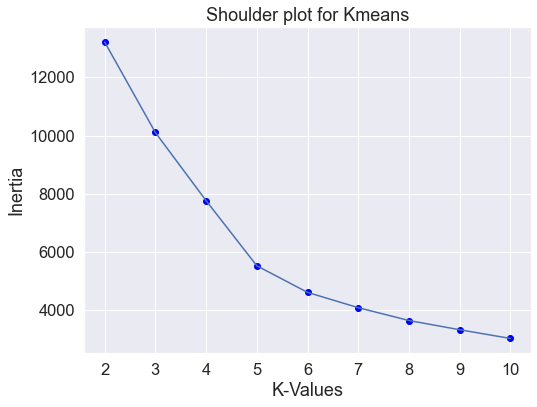


The best number of clusters based on shoulder plot are 9


In [44]:
# Perform K-Means clustering
inertias = [] 
sil_scores = []
max_cl = 10
K = range(2, max_cl+1) 
prev_inertia = 10000000
tolerance = 0.1 # When change in inertia equals tolerance for the first time, that cluster is the "shoulder"
num_entries = 0

for k in K: 
    #Building and fitting the model 
    Kmodel = KMeans(n_clusters=k,
                  init='k-means++', #selects initial cluster centers for k-means clustering in a smart way to speed up convergence.
                  random_state=42) 
    Kmodel = Kmodel.fit(X_Scaled)  
    score = silhouette_score(X_Scaled, Kmodel.labels_, metric='euclidean')
    sil_scores.append(score)
    
    inertias.append(Kmodel.inertia_)
    current_inertia = Kmodel.inertia_
    
    if (num_entries==0) & ((prev_inertia - current_inertia)/(prev_inertia) < tolerance): # First time the code enters here would be the best cluster (it would represent shoulder)
        best_cluster = k
        num_entries=1
    
    prev_inertia = Kmodel.inertia_
    
plt.figure(figsize=(8, 6))

plt.scatter(range (2, max_cl+1), inertias, c='blue')
plt.plot(range(2,max_cl+1),inertias)
plt.title('Shoulder plot for Kmeans')
plt.xlabel('K-Values')
plt.ylabel('Inertia')
plt.show()

print(f"\nThe best number of clusters based on shoulder plot are {best_cluster}")

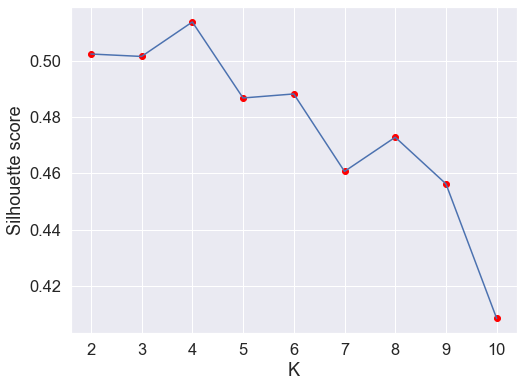


The best number of clusters based on silhouette score are 4


In [45]:
# Plot silhouette scores and find the K with highest score
plt.figure(figsize=(8, 6))
plt.scatter(range (2, max_cl+1), sil_scores, c='red')
plt.plot(range(2,max_cl+1),sil_scores)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

print(f"\nThe best number of clusters based on silhouette score are {sil_scores.index(max(sil_scores))+2}")

In [46]:
# Create a kmeans model with the best K based on shoulder plot
KMeans_model_shoulder = KMeans(n_clusters=best_cluster, init='k-means++', random_state=42)
KMeans_model_shoulder = KMeans_model_shoulder.fit(X_Scaled)
labels = KMeans_model_shoulder.labels_

# Find the silhouette score
score = silhouette_score(X_Scaled, KMeans_model_shoulder.labels_, metric='euclidean')
print('Silhouette Score for KMeans: %.3f' % score)

Silhouette Score for KMeans: 0.456


In [47]:
# Check the cluster distribution
pd.Series(labels).value_counts()

0    1937
5     871
1     550
8     189
7      95
6      80
4      29
3      21
2       1
dtype: int64

### As seen above, few of the clusters have very less data.

In [48]:
# Create a kmeans model with the best K based on silhouette score
best_cluster_sil = sil_scores.index(max(sil_scores))+2
KMeans_model_sil = KMeans(n_clusters=best_cluster_sil, init='k-means++', random_state=42)
KMeans_model_sil = KMeans_model_sil.fit(X_Scaled)
labels = KMeans_model_sil.labels_

# Find the silhouette score
score = silhouette_score(X_Scaled, KMeans_model_sil.labels_, metric='euclidean')
print('Silhouette Score for KMeans: %.3f' % score)

Silhouette Score for KMeans: 0.514


In [49]:
# Check the cluster distribution
pd.Series(labels).value_counts()

1    2780
0     937
2      55
3       1
dtype: int64

### Four Clusters formed using silhouette score. But, as seen above we still have clusters with very less customers.

#### DBSCAN

In [50]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_Scaled)
distances, indices = nbrs.kneighbors(X_Scaled)

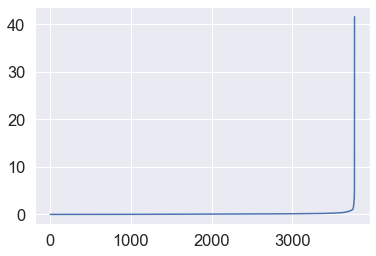

In [51]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [52]:
dbscan_model = DBSCAN(eps=0.25, min_samples=10)
dbscan_model = dbscan_model.fit(X_Scaled)
core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
core_samples_mask[dbscan_model.core_sample_indices_] = True
labels = dbscan_model.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 873


In [53]:
# Count of customers in each group(label)
pd.Series(labels).value_counts() 

 0    2881
-1     873
 1      13
 2       6
dtype: int64

In [54]:
# Check Silhouette score of DBSCAN clusters
score = silhouette_score(X_Scaled, labels, metric='euclidean')
print(f'Silhouette Score for DbScan: {score}')

Silhouette Score for DbScan: 0.0332168077521621


In [55]:
# As seen above DBSCAN has indentified lot of records as noise points, but as we dont want to ignore those points(customers), 
#   moving with K-means determined clusters.
# Also, best number of clusters determined from K-means cluster analysis has got very few data points in two clusters. 
#   So trying with one less than best clusters from K-means
KMeans_model_shoulder = KMeans(n_clusters=best_cluster_sil-1, init='k-means++', random_state=42)
KMeans_model_shoulder = KMeans_model_shoulder.fit(X_Scaled)
labels = KMeans_model_shoulder.labels_

# Check silhoutte score
score = silhouette_score(X_Scaled, KMeans_model_shoulder.labels_, metric='euclidean')
print('Silhouette Score for KMeans: %.3f' % score)

Silhouette Score for KMeans: 0.502


In [56]:
# Count of customers in each group(label)
pd.Series(labels).value_counts()

0    2840
1     932
2       1
dtype: int64

- Silhouette score for K=4 is 0.514
- Silhouette score for K=3 is 0.502
### As K=3 has better distribution of data compared to K=4, and has near about same silhouette score. Considering K=3 for further analysis.

In [57]:
# There is one cluster with only one datapoint in it. So ignoring that cluster for further steps. So, effective number of clusters becomes 2.
cluster_number = KMeans_model_shoulder.fit_predict(X_Scaled)
trans_group_no_outlier['Cluster_No'] = cluster_number

# Remove row with cluster number 2 as it has only one entry
final_df = trans_group_no_outlier[trans_group_no_outlier['Cluster_No']!=2]
final_df.head()

<ipython-input-57-79c83ef61cc5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_group_no_outlier['Cluster_No'] = cluster_number


,num_days_involved,num_transactions,num_units,money_spent,AOV,profit_margin,CV,CLTV,Cluster_No
CustomerID,,,,,,,,,
12747,347,96,1153,3757.51,39.140729,150.3004,194743.821684,292.700743,1
12749,190,159,1243,3277.82,20.615220,131.1128,102570.566201,134.483141,1
12820,282,47,607,731.99,15.574255,29.2796,77489.358663,22.688574,0
12821,0,6,70,92.72,15.453333,3.7088,76887.714030,2.851612,0
12822,16,46,550,948.88,20.627826,37.9552,102633.286879,38.954669,0


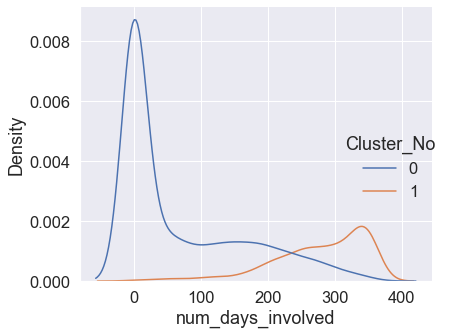

In [58]:
# Additional info
sns.displot(data=final_df, x='num_days_involved', hue='Cluster_No', kind='kde')
plt.tight_layout()

### Classification

In [59]:
def plot_roc_curve(model, yTest, yPred):  # This works for Binary classifiaction 
    fpr, tpr, thresholds = roc_curve(yTest, yPred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    Model_accuracy[model] = roc_auc_score(yTest, yPred)
    print('AUC roc_auc_score:', roc_auc_score(yTest, yPred))
    plt.plot([0,1],[0,1],'k--')
    #plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(model)
    plt.show()

# Outputs all classification metrics
def getModelReport(modelName, yTest, yPredict) :
    accuracy    = accuracy_score(yTest, yPredict)
    precision   = precision_score(yTest, yPredict)
    recall      = recall_score(yTest, yPredict)
    f1          = f1_score(yTest, yPredict)
    conf_matrix = confusion_matrix(yTest, yPredict)
    clf_report  = classification_report(yTest, yPredict)

    print('\n\n*************************************************************************************')
    print('FOR {0}:'.format(modelName))
    print('ACCURACY:', accuracy)
    print('F1 SCORE:', f1)
    print('CONFUSION MATRIX: ')
    print(conf_matrix)    
    print('CLASSIFICATION REPORT: ')
    print(clf_report)
    print('****************************************************************************************')
    return f1

# Classification. Pipeline -> Scale - classifier   
def classification_model(X_tr, y_tr, X_te, y_te, model, metrics):
    pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', model)])
    scores   = cross_validate(pipeline, X_tr, y_tr, cv=10, scoring=metrics, return_estimator=True, n_jobs=-1)
    
    max_index      = scores['test_f1_micro'].argmax()
    best_estimator = scores['estimator'][max_index]
    
    y_pred = best_estimator.predict(X_te) 
    return y_pred

# Function to oversample minority class, such that distribution is 60:40
def custom_oversample(target):
    prop = pd.Series(np.bincount(target)).sort_values(ascending=False)
    # iloc here gives sorted order. That means, first index has highest number of samples, and last index has least samples.
    prop.iloc[1] = int(4/6 * prop.iloc[0]) # Makes samples in 60:40 ratio
    return prop.to_dict()

# Classification. Pipeline -> Scale - Smote - classifier
def classification_model_smote(X_tr, y_tr, X_te, y_te, model, metrics):   
    over           =  SMOTE(random_state = 42, sampling_strategy=custom_oversample)
   
    pipeline       =  sm_pipe([('scaler', StandardScaler()), ('smote', over), ('estimator', model)])
    scores         =  cross_validate(pipeline, X_tr, y_tr, cv=10, scoring=metrics, return_estimator=True, n_jobs=-1)
    
    max_index      =  scores['test_f1_micro'].argmax()
    best_estimator =  scores['estimator'][max_index] 
    y_pred         =  best_estimator.predict(X_te)
    return y_pred

In [60]:
# Check Target Label distribution
final_df[['Cluster_No']].value_counts()

Cluster_No
0             2840
1              932
dtype: int64

In [61]:
# Prepare training and test datasets using stratified sampling
X     =   final_df[['num_days_involved','num_transactions','money_spent','AOV','CLTV']]
y     =   final_df[['Cluster_No']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

#### Logistic Regression



*************************************************************************************
FOR Logistic_Regression:
ACCURACY: 1.0
F1 SCORE: 1.0
CONFUSION MATRIX: 
[[285   0]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00        93

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 1.0


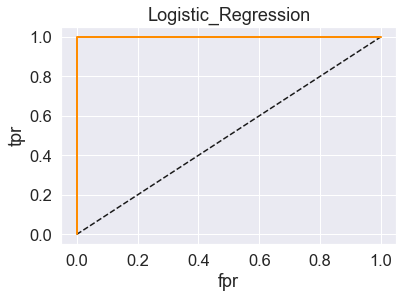

In [62]:
logreg        = LogisticRegression()
logreg_output = classification_model(X_train, y_train, X_test, y_test, logreg, ('f1_micro','roc_auc_ovr'))

# Check the metrics
logreg_f1 = getModelReport("Logistic_Regression", y_test, logreg_output)
plot_roc_curve("Logistic_Regression", y_test, logreg_output)

#### KNN



*************************************************************************************
FOR KNN:
ACCURACY: 0.9947089947089947
F1 SCORE: 0.9893617021276596
CONFUSION MATRIX: 
[[283   2]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       285
           1       0.98      1.00      0.99        93

    accuracy                           0.99       378
   macro avg       0.99      1.00      0.99       378
weighted avg       0.99      0.99      0.99       378

****************************************************************************************
AUC roc_auc_score: 0.9964912280701754


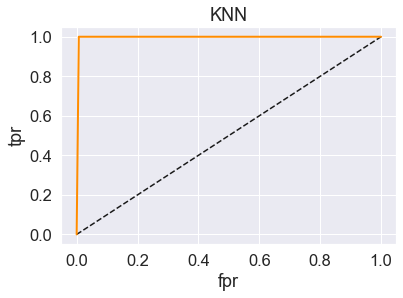

In [63]:
knn        = KNeighborsClassifier(n_neighbors=5)
knn_output = classification_model(X_train, y_train, X_test, y_test, knn, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
knn_f1 = getModelReport("KNN", y_test, knn_output)
plot_roc_curve("KNN", y_test, knn_output)

#### Random forest



*************************************************************************************
FOR Random_Forest:
ACCURACY: 0.9920634920634921
F1 SCORE: 0.983957219251337
CONFUSION MATRIX: 
[[283   2]
 [  1  92]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       285
           1       0.98      0.99      0.98        93

    accuracy                           0.99       378
   macro avg       0.99      0.99      0.99       378
weighted avg       0.99      0.99      0.99       378

****************************************************************************************
AUC roc_auc_score: 0.9911148839841539


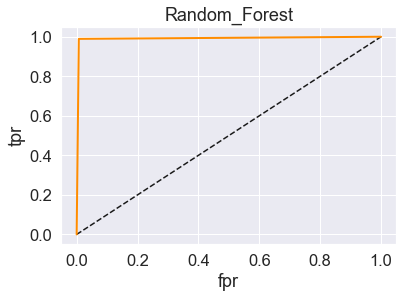

In [64]:
rf        = RandomForestClassifier(n_estimators= 1000, random_state=42)
rf_output = classification_model(X_train, y_train, X_test, y_test, rf, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
rf_f1 = getModelReport("Random_Forest", y_test, rf_output)
plot_roc_curve("Random_Forest", y_test, rf_output)

#### SVM



*************************************************************************************
FOR SVM_Linear:
ACCURACY: 1.0
F1 SCORE: 1.0
CONFUSION MATRIX: 
[[285   0]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00        93

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 1.0


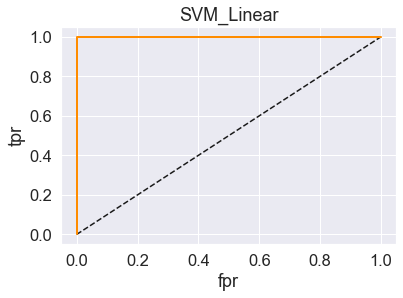

In [65]:
# Linear SVM
svc_lin        = SVC(kernel='linear', C=100, gamma='auto', probability=True)
svc_lin_output = classification_model(X_train, y_train, X_test, y_test, svc_lin, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
svc_lin_f1 = getModelReport("SVM_Linear", y_test, svc_lin_output)
plot_roc_curve("SVM_Linear", y_test, svc_lin_output)



*************************************************************************************
FOR SVM_RBF:
ACCURACY: 1.0
F1 SCORE: 1.0
CONFUSION MATRIX: 
[[285   0]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00        93

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 1.0


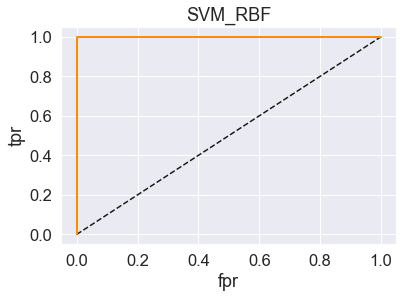

In [66]:
# SVM with RBF Kernal
svc_rbf        = SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
svc_rbf_output = classification_model(X_train, y_train, X_test, y_test, svc_rbf, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
svc_rbf_f1 = getModelReport("SVM_RBF", y_test, svc_rbf_output)
plot_roc_curve("SVM_RBF", y_test, svc_rbf_output)



*************************************************************************************
FOR SVM_Poly:
ACCURACY: 1.0
F1 SCORE: 1.0
CONFUSION MATRIX: 
[[285   0]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00        93

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 1.0


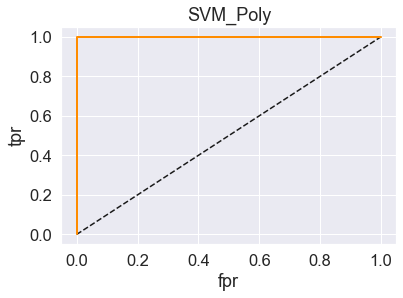

In [67]:
# SVM with Polynomial Kernal
svc_poly        = SVC(kernel='poly', C=100, gamma='auto', degree=3,coef0=1,probability=True)
svc_poly_output = classification_model(X_train, y_train, X_test, y_test, svc_poly, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
svc_poly_f1 = getModelReport("SVM_Poly", y_test, svc_poly_output)
plot_roc_curve("SVM_Poly", y_test, svc_poly_output)

#### Bagging



*************************************************************************************
FOR Bagging:
ACCURACY: 0.9947089947089947
F1 SCORE: 0.9893617021276596
CONFUSION MATRIX: 
[[283   2]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       285
           1       0.98      1.00      0.99        93

    accuracy                           0.99       378
   macro avg       0.99      1.00      0.99       378
weighted avg       0.99      0.99      0.99       378

****************************************************************************************
AUC roc_auc_score: 0.9964912280701754


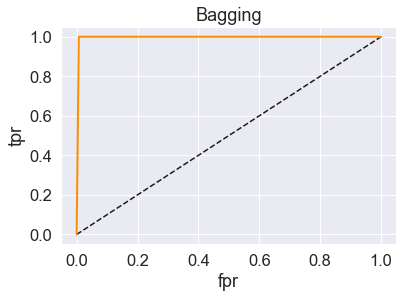

In [68]:
# Bagging Classifier
bag        = BaggingClassifier(n_estimators=1000, random_state=42)
bag_output = classification_model(X_train, y_train, X_test, y_test, bag, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
bag_f1 = getModelReport("Bagging", y_test, bag_output)
plot_roc_curve("Bagging", y_test, bag_output)

#### Gradient boosting



*************************************************************************************
FOR Gradient_Boosting:
ACCURACY: 0.9973544973544973
F1 SCORE: 0.9946524064171123
CONFUSION MATRIX: 
[[284   1]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       0.99      1.00      0.99        93

    accuracy                           1.00       378
   macro avg       0.99      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 0.9982456140350877


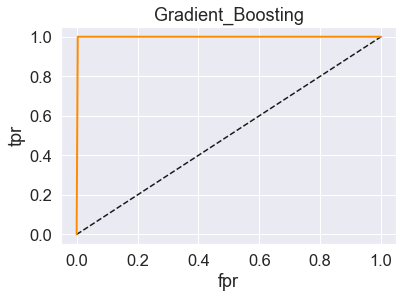

In [69]:
gb        = GradientBoostingClassifier(n_estimators=1000, random_state=42)
gb_output = classification_model(X_train, y_train, X_test, y_test, gb, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
gb_f1 = getModelReport("Gradient_Boosting", y_test, gb_output)
plot_roc_curve("Gradient_Boosting", y_test, gb_output)

#### MLP



*************************************************************************************
FOR Deep_Network:
ACCURACY: 1.0
F1 SCORE: 1.0
CONFUSION MATRIX: 
[[285   0]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00        93

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 1.0


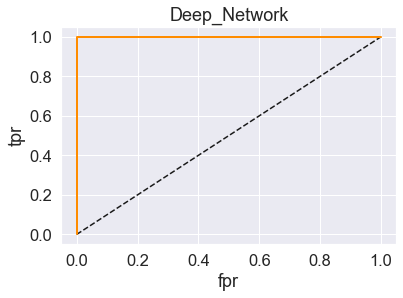

In [70]:
deepnet        = MLPClassifier(hidden_layer_sizes = (10, 4), solver='sgd', max_iter=1000, random_state=42)
deepnet_output = classification_model(X_train, y_train, X_test, y_test, deepnet, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
deepnet_f1 = getModelReport("Deep_Network", y_test, deepnet_output)
plot_roc_curve("Deep_Network", y_test, deepnet_output)

In [71]:
# Write the model predictions to a dataframe
Model_Predictions_clf = {}
Model_Predictions_clf['CustomerID']     = y_test.index
Model_Predictions_clf['Class']          = y_test.Cluster_No.to_numpy()

Model_Predictions_clf['Logistic_Regression'] = logreg_output
Model_Predictions_clf['KNN']                 = knn_output
Model_Predictions_clf['Random_Forest']       = rf_output
Model_Predictions_clf['SVM_Linear']          = svc_lin_output
Model_Predictions_clf['SVM_RBF']             = svc_rbf_output
Model_Predictions_clf['SVM_Poly']            = svc_poly_output
Model_Predictions_clf['Bagging']             = bag_output
Model_Predictions_clf['Gradient_Boosting']   = gb_output
Model_Predictions_clf['Deep_Network']        = deepnet_output

Model_Predictions_clf = pd.DataFrame.from_dict(Model_Predictions_clf)

# Save the final results to a csv file
Model_Predictions_clf.to_csv(OutputdataFolder + "/CustomerClass_Predictions_Classification.csv", index=False)

In [72]:
# Sort the model based on best ROC AUC Score
df_AUC_clf = pd.Series(Model_accuracy)
df_AUC_clf.sort_values(ascending=False, inplace=True)
df_AUC_clf

Deep_Network           1.000000
SVM_Poly               1.000000
SVM_RBF                1.000000
SVM_Linear             1.000000
Logistic_Regression    1.000000
Gradient_Boosting      0.998246
Bagging                0.996491
KNN                    0.996491
Random_Forest          0.991115
dtype: float64

## SMOTE + Classification

Though we have good results from classification(above), we just want to explore this technique(SMOTE) of creating synthetic datapoints to balance the dataset.

#### Logistic Regression



*************************************************************************************
FOR Logistic_Regression_Smote:
ACCURACY: 0.9947089947089947
F1 SCORE: 0.9893617021276596
CONFUSION MATRIX: 
[[283   2]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       285
           1       0.98      1.00      0.99        93

    accuracy                           0.99       378
   macro avg       0.99      1.00      0.99       378
weighted avg       0.99      0.99      0.99       378

****************************************************************************************
AUC roc_auc_score: 0.9964912280701754


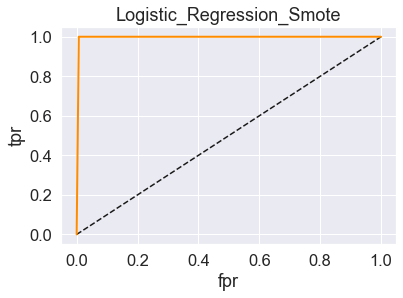

In [73]:
logreg_smote        = LogisticRegression()
logreg_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, logreg_smote, ('f1_micro','roc_auc_ovr'))

# Check the metrics
getModelReport("Logistic_Regression_Smote", y_test, logreg_smote_output)
plot_roc_curve("Logistic_Regression_Smote", y_test, logreg_smote_output)

#### KNN



*************************************************************************************
FOR KNN_Smote:
ACCURACY: 0.9920634920634921
F1 SCORE: 0.9841269841269841
CONFUSION MATRIX: 
[[282   3]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       285
           1       0.97      1.00      0.98        93

    accuracy                           0.99       378
   macro avg       0.98      0.99      0.99       378
weighted avg       0.99      0.99      0.99       378

****************************************************************************************
AUC roc_auc_score: 0.9947368421052631


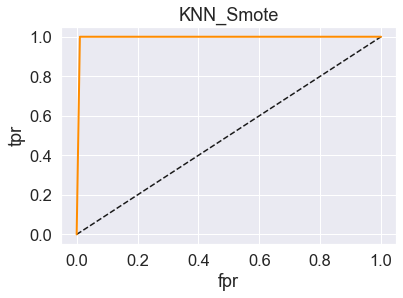

In [74]:
knn_smote        = KNeighborsClassifier(n_neighbors=5)
knn_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, knn_smote, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
getModelReport("KNN_Smote", y_test, knn_smote_output)
plot_roc_curve("KNN_Smote", y_test, knn_smote_output)

#### Random forest



*************************************************************************************
FOR Random_Forest_Smote:
ACCURACY: 0.9894179894179894
F1 SCORE: 0.9787234042553192
CONFUSION MATRIX: 
[[282   3]
 [  1  92]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       285
           1       0.97      0.99      0.98        93

    accuracy                           0.99       378
   macro avg       0.98      0.99      0.99       378
weighted avg       0.99      0.99      0.99       378

****************************************************************************************
AUC roc_auc_score: 0.9893604980192416


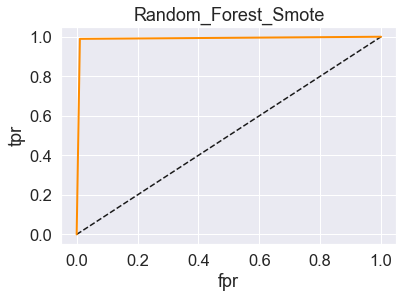

In [75]:
rf_smote        = RandomForestClassifier(n_estimators= 1000, random_state=42)
rf_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, rf_smote, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
getModelReport("Random_Forest_Smote", y_test, rf_smote_output)
plot_roc_curve("Random_Forest_Smote", y_test, rf_smote_output)

#### SVM



*************************************************************************************
FOR SVM_Linear_Smote:
ACCURACY: 1.0
F1 SCORE: 1.0
CONFUSION MATRIX: 
[[285   0]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00        93

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 1.0


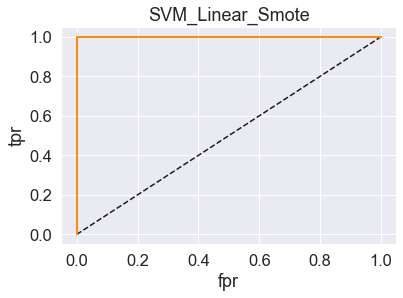

In [76]:
# Linear SVM
svc_lin_smote        = SVC(kernel='linear', C=100, gamma='auto', probability=True)
svc_lin_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, svc_lin_smote, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
getModelReport("SVM_Linear_Smote", y_test, svc_lin_smote_output)
plot_roc_curve("SVM_Linear_Smote", y_test, svc_lin_smote_output)



*************************************************************************************
FOR SVM_RBF_Smote:
ACCURACY: 1.0
F1 SCORE: 1.0
CONFUSION MATRIX: 
[[285   0]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00        93

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 1.0


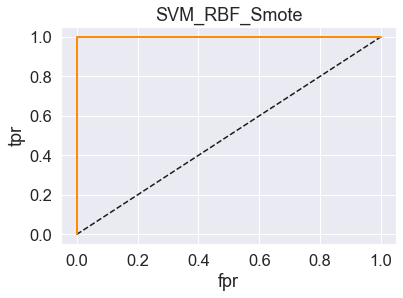

In [77]:
# SVM with RBF Kernal
svc_rbf_smote        = SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
svc_rbf_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, svc_rbf_smote, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
getModelReport("SVM_RBF_Smote", y_test, svc_rbf_smote_output)
plot_roc_curve("SVM_RBF_Smote", y_test, svc_rbf_smote_output)



*************************************************************************************
FOR SVM_Poly_Smote:
ACCURACY: 1.0
F1 SCORE: 1.0
CONFUSION MATRIX: 
[[285   0]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00        93

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378

****************************************************************************************
AUC roc_auc_score: 1.0


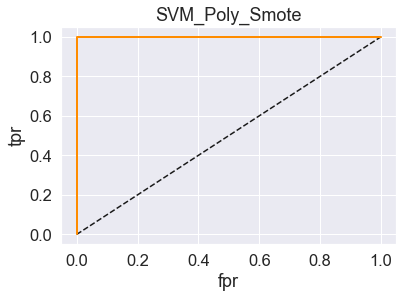

In [78]:
# SVM with Polynomial Kernal
svc_poly_smote        = SVC(kernel='poly', C=100, gamma='auto', degree=3, coef0=1, probability=True)
svc_poly_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, svc_poly_smote, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
getModelReport("SVM_Poly_Smote", y_test, svc_poly_smote_output)
plot_roc_curve("SVM_Poly_Smote", y_test, svc_poly_smote_output)

#### Bagging



*************************************************************************************
FOR Bagging_Smote:
ACCURACY: 0.9894179894179894
F1 SCORE: 0.9787234042553192
CONFUSION MATRIX: 
[[282   3]
 [  1  92]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       285
           1       0.97      0.99      0.98        93

    accuracy                           0.99       378
   macro avg       0.98      0.99      0.99       378
weighted avg       0.99      0.99      0.99       378

****************************************************************************************
AUC roc_auc_score: 0.9893604980192416


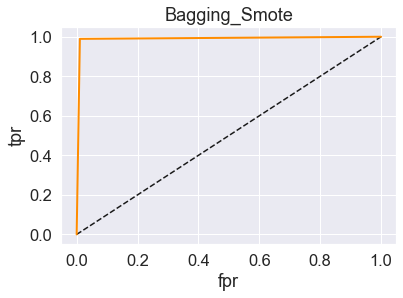

In [79]:
# Bagging Classifier
bag_smote        = BaggingClassifier(n_estimators=1000, random_state=42)
bag_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, bag_smote, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
getModelReport("Bagging_Smote", y_test, bag_smote_output)
plot_roc_curve("Bagging_Smote", y_test, bag_smote_output)

#### Gradient boosting



*************************************************************************************
FOR Gradient_Boosting_Smote:
ACCURACY: 0.9947089947089947
F1 SCORE: 0.9893617021276596
CONFUSION MATRIX: 
[[283   2]
 [  0  93]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       285
           1       0.98      1.00      0.99        93

    accuracy                           0.99       378
   macro avg       0.99      1.00      0.99       378
weighted avg       0.99      0.99      0.99       378

****************************************************************************************
AUC roc_auc_score: 0.9964912280701754


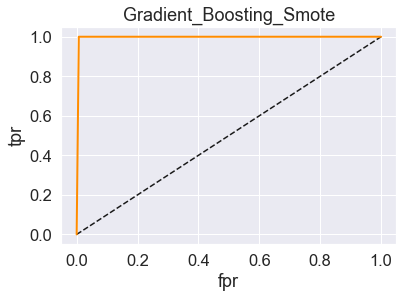

In [80]:
gb_smote        = GradientBoostingClassifier(n_estimators=1000, random_state=42)
gb_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, gb_smote, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
getModelReport("Gradient_Boosting_Smote", y_test, gb_smote_output)
plot_roc_curve("Gradient_Boosting_Smote", y_test, gb_smote_output)

#### MLP

In [ ]:
deepnet_smote        = MLPClassifier(hidden_layer_sizes = (10, 4), solver='sgd', max_iter=1000, random_state=42)
deepnet_smote_output = classification_model_smote(X_train, y_train, X_test, y_test, deepnet_smote, ('f1_micro', 'roc_auc_ovr'))

# Check the metrics
getModelReport("Deep_Network_Smote", y_test, deepnet_smote_output)
plot_roc_curve("Deep_Network_Smote", y_test, deepnet_smote_output)